PATTERN RECOGNITION AND MACHINE INTELLIGENCE IN MEDICINE

In [1]:
!unzip "/content/drive/MyDrive/COVID-19_Radiography_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model

OBTAINING DATASET:

In [3]:
c = './COVID-19_Radiography_Dataset/COVID/images'
n = './COVID-19_Radiography_Dataset/Normal/images'
p = './COVID-19_Radiography_Dataset/Viral Pneumonia/images'
l = './COVID-19_Radiography_Dataset/Lung_Opacity/images'

In [4]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n),6000) + os.listdir(p) + os.listdir(l)

CATEGORIZING DATASET BASED IN IMAGE NAMES:

In [5]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    elif category == 'Lung_Opacity':
        categories.append(str(3))
    else:
        categories.append(str(0))

In [6]:
print(len(categories))
unique, counts = np.unique(categories, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

16973
[['0' '6000']
 ['1' '1345']
 ['2' '3616']
 ['3' '6012']]


SAVING IMAGE DIRECTORIES AND THE CATEGORIES IN THE VARIABLE:

In [7]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    elif 'Lung_Opacity' in filenames[i]:
        filenames[i] = os.path.join(l, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

VISUALISING THE DATASET:

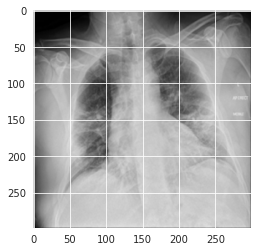

COVID


In [8]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()
a=sample.split('/')[-1]
b=a.split('-')[0]
print(b)

SPLITTING THE DATASET INTO TRAIN,TEST AND VALIDATION:

In [9]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [10]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

DATA AUGMENTATION:

In [11]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [12]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 13578 validated image filenames belonging to 4 classes.


In [13]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 1698 validated image filenames belonging to 4 classes.


DESIGNING THE MODEL:

In [14]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False


58900480/58889256 [==============================] - 0s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

TRAINING WITH THE ADAM OPTIMIZER:

In [16]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',])

In [17]:
epochs = 10
history = model.fit_generator(train_generator, epochs=epochs,
                              validation_data=valid_generator, verbose=1)

Epoch 1/10
425/425 [==============================] - 254s 568ms/step - loss: 0.8656 - accuracy: 0.6476 - val_loss: 0.6564 - val_accuracy: 0.7161
Epoch 2/10
425/425 [==============================] - 235s 553ms/step - loss: 0.6605 - accuracy: 0.7473 - val_loss: 0.5433 - val_accuracy: 0.7821
Epoch 3/10
425/425 [==============================] - 235s 554ms/step - loss: 0.5819 - accuracy: 0.7810 - val_loss: 0.5169 - val_accuracy: 0.7945
Epoch 4/10
425/425 [==============================] - 234s 550ms/step - loss: 0.5518 - accuracy: 0.7928 - val_loss: 0.5108 - val_accuracy: 0.7956
Epoch 5/10
425/425 [==============================] - 232s 547ms/step - loss: 0.5161 - accuracy: 0.8059 - val_loss: 0.4801 - val_accuracy: 0.8104
Epoch 6/10
425/425 [==============================] - 231s 543ms/step - loss: 0.4936 - accuracy: 0.8140 - val_loss: 0.4356 - val_accuracy: 0.8351
Epoch 7/10
425/425 [==============================] - 233s 547ms/step - loss: 0.4842 - accuracy: 0.8211 - val_loss: 0.4131 -

In [ ]:
model.save('model_without_preprocessed1.h5')

PLOTTING THE ACCURACY AND LOSS FOR THE ABOVE MODEL:

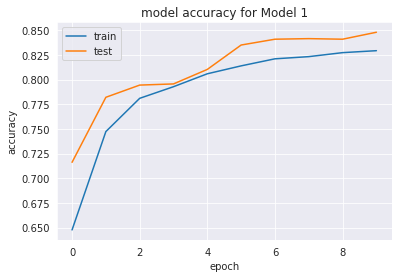

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy for Model 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

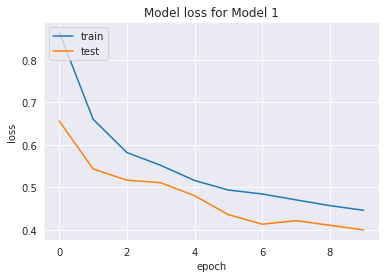

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for Model 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_generator)

54/54 [==============================] - 16s 288ms/step - loss: 0.3991 - accuracy: 0.8515


[0.3991178870201111, 0.8515026569366455]

In [20]:
sample = (test_data['filename'])

In [21]:
pred=[]
for i in sample:
  image = load_img(i, target_size=(224, 224))
  img = img_to_array(image)
  img = img.reshape((1, 224, 224, 3))
  img=img/255.0
  result = model.predict(img)
  result = np.argmax(result, axis=-1)
  pred=np.hstack((pred,result))

In [22]:
actual=np.array(test_data['category'])
pred=pred.astype(int)

CONFUSION MATRIX FOR THE MODEL WITH ADAM OPTIMIZER:

[[555  21  71  74]
 [  4 111   0   0]
 [  8   1 244  12]
 [ 33   2  46 515]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       721
           1       0.82      0.97      0.89       115
           2       0.68      0.92      0.78       265
           3       0.86      0.86      0.86       596

    accuracy                           0.84      1697
   macro avg       0.82      0.88      0.84      1697
weighted avg       0.86      0.84      0.84      1697



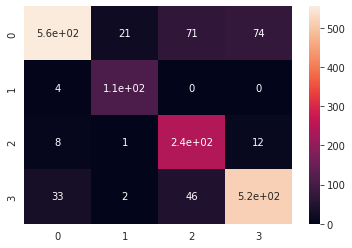

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(pred.astype(str),actual.astype(str)), annot=True)
print(confusion_matrix(pred.astype(str),actual.astype(str)))
print(classification_report(pred.astype(str),actual.astype(str)))

TRAINING WITH THE STOCHASTIC GRADIENT DESCENT OPTIMIZER:

In [24]:
from tensorflow.keras.optimizers import SGD
model2 = Model(inputs=baseModel.input, outputs=headModel)
opt2 = SGD(learning_rate=0.0001)
model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
epochs = 10
history2 = model2.fit_generator(train_generator, epochs=epochs,
                              validation_data=valid_generator, verbose=1)

Epoch 1/10
425/425 [==============================] - 235s 551ms/step - loss: 0.4302 - accuracy: 0.8370 - val_loss: 0.3921 - val_accuracy: 0.8516
Epoch 2/10
425/425 [==============================] - 234s 551ms/step - loss: 0.4223 - accuracy: 0.8414 - val_loss: 0.3910 - val_accuracy: 0.8528
Epoch 3/10
425/425 [==============================] - 233s 547ms/step - loss: 0.4261 - accuracy: 0.8399 - val_loss: 0.3894 - val_accuracy: 0.8539
Epoch 4/10
425/425 [==============================] - 234s 551ms/step - loss: 0.4232 - accuracy: 0.8425 - val_loss: 0.3886 - val_accuracy: 0.8557
Epoch 5/10
425/425 [==============================] - 234s 551ms/step - loss: 0.4313 - accuracy: 0.8361 - val_loss: 0.3942 - val_accuracy: 0.8481
Epoch 6/10
425/425 [==============================] - 232s 546ms/step - loss: 0.4282 - accuracy: 0.8395 - val_loss: 0.3926 - val_accuracy: 0.8498
Epoch 7/10
425/425 [==============================] - 233s 549ms/step - loss: 0.4288 - accuracy: 0.8380 - val_loss: 0.3914 -

In [ ]:
model2.save('model_without_preprocessed2.h5')

PLOTTING MODEL ACCURACY AND LOSS FOR THE MODEL 2:

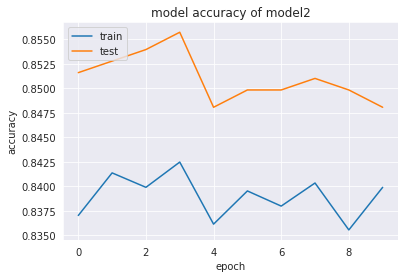

In [26]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of model2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

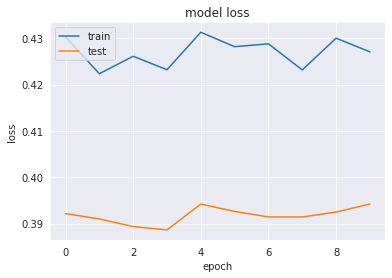

In [27]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

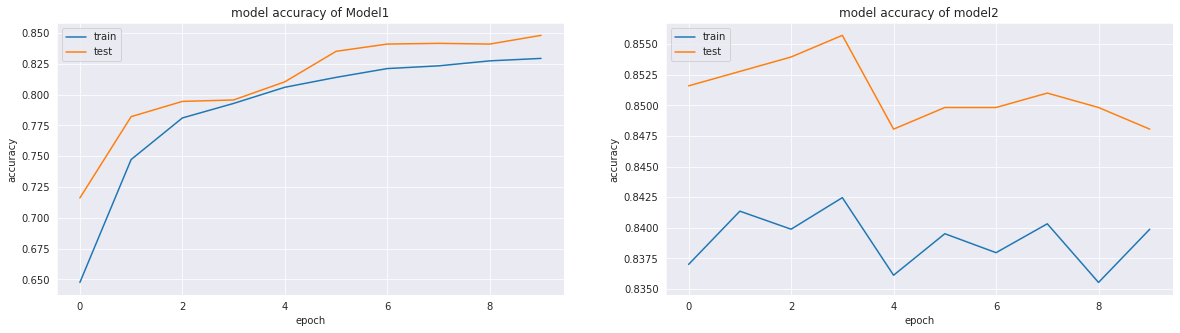

In [28]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of Model1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of model2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

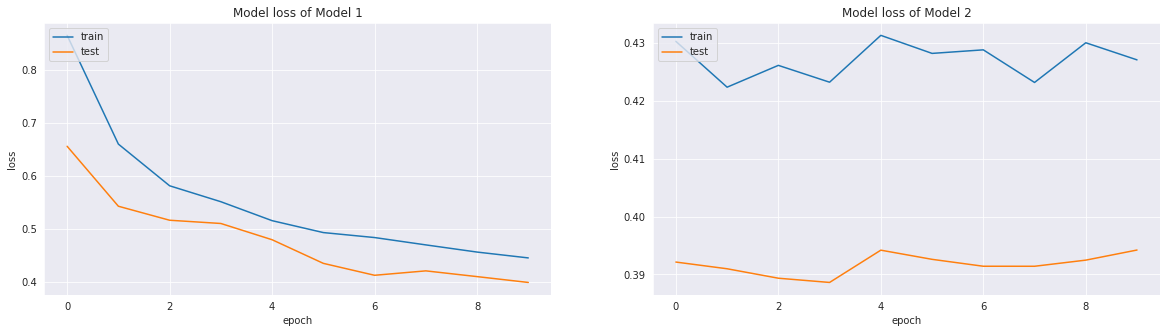

In [31]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss of Model 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss of Model 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
pred2=[]
for i in sample:
  image = load_img(i, target_size=(224, 224))
  img = img_to_array(image)
  img = img.reshape((1, 224, 224, 3))
  img=img/255.0
  result2 = model2.predict(img)
  result2 = np.argmax(result2, axis=-1)
  pred2=np.hstack((pred2,result2))

In [33]:
actual=np.array(test_data['category'])
pred2=pred2.astype(int)

CONFUSION MATRIX FOR THE MODEL 2:

[[556  14  69  78]
 [  4 119   0   0]
 [  8   1 245  13]
 [ 32   1  47 510]]
              precision    recall  f1-score   support

           0       0.93      0.78      0.84       717
           1       0.88      0.97      0.92       123
           2       0.68      0.92      0.78       267
           3       0.85      0.86      0.86       590

    accuracy                           0.84      1697
   macro avg       0.83      0.88      0.85      1697
weighted avg       0.86      0.84      0.84      1697



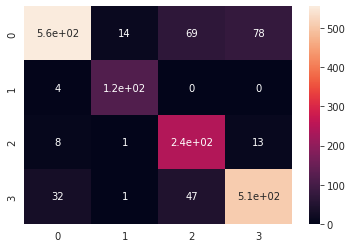

In [34]:
sns.heatmap(confusion_matrix(pred2.astype(str),actual.astype(str)), annot=True)
print(confusion_matrix(pred2.astype(str),actual.astype(str)))
print(classification_report(pred2.astype(str),actual.astype(str)))